In [1]:
### automatically refresh the buffer

%load_ext autoreload
%autoreload 2

### solve the auto-complete issue

%config Completer.use_jedi = False

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

### lvl 2 setups (systerm)

import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import warnings
warnings.filterwarnings('ignore')
from pylab import *
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Wedge, Circle
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime
import datetime

import glob

In [2]:
ds_404 = xr.open_dataset('/N/project/Zli_lab/Data/Observations/NCAR/prec_acc_files/PREC_ACC_NC.wrf2d_d01_2022-09-30_23:00:00.nc')

In [4]:
US = gpd.read_file('/N/project/Zli_lab/Data/Other/tl_2019_us_state/tl_2019_us_state.shp')
regions_dict = {
    'CONUS': ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT', 'WV',
    'IA', 'MI', 'MN', 'WI', 'IL', 'IN', 'MO', 'OH', 'AL', 'FL', 'GA', 'NC', 
    'SC', 'VA', 'TN', 'KY', 'AR', 'LA', 'MS', 'MT', 'NE', 'ND', 'SD', 'WY', 
    'KS', 'OK', 'TX', 'AZ', 'CO', 'NM', 'UT', 'CA', 'NV', 'ID', 'OR', 'WA']
}
regions = {name: US[US['STUSPS'].isin(states)] for name, states in regions_dict.items()}

In [5]:
# 获取 XLAT 和 XLONG 并转换为 DataFrame
lon = ds_404['XLONG'].values  # shape: (1015, 1367)
lat = ds_404['XLAT'].values   # shape: (1015, 1367)

# 创建 GeoDataFrame（将 XLONG 和 XLAT 转换为点）
grid_points = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(lon.flatten(), lat.flatten()), 
    index=pd.MultiIndex.from_product([range(lon.shape[0]), range(lon.shape[1])], names=['south_north', 'west_east'])
)
grid_points.set_crs(regions['CONUS'].crs, inplace=True)  # 设置 CRS 与 shapefile 一致

# 进行空间连接，筛选 CONUS 内的点
grid_filtered = gpd.sjoin(grid_points, regions['CONUS'], how='inner', predicate='within')

# 创建 xarray 掩码
mask = np.full((lon.shape[0], lon.shape[1]), False)  # 初始化全 False
for (row, col) in grid_filtered.index:
    mask[row, col] = True  # 标记落入区域的点为 True

# 转换为 xarray DataArray
mask_da = xr.DataArray(mask, dims=('south_north', 'west_east'), coords={'south_north': ds_404['south_north'], 'west_east': ds_404['west_east']})

# 只保留 CONUS 内的降水数据
ds_filtered = ds_404.where(mask_da, drop=True)

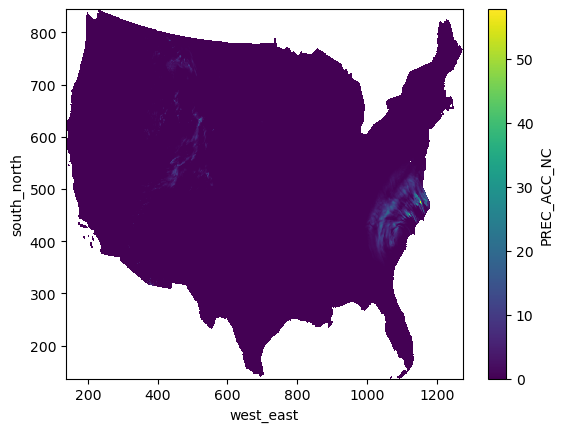

In [6]:
ds_filtered.mean('Time').PREC_ACC_NC.plot()
plt.show()

In [7]:
ds_filtered

<xarray.Dataset> Size: 10MB
Dimensions:      (Time: 1, south_north: 708, west_east: 1137)
Coordinates:
  * Time         (Time) datetime64[ns] 8B 2022-09-30T23:00:00
    XLAT         (south_north, west_east) float32 3MB 23.44 23.45 ... 47.41
    XLONG        (south_north, west_east) float32 3MB -118.9 -118.9 ... -65.54
    XTIME        (Time) datetime64[ns] 8B ...
  * south_north  (south_north) int64 6kB 137 138 139 140 141 ... 841 842 843 844
  * west_east    (west_east) int64 9kB 138 139 140 141 ... 1271 1272 1273 1274
Data variables:
    PREC_ACC_NC  (Time, south_north, west_east) float32 3MB nan nan ... nan nan
Attributes: (12/151)
    TITLE:                            OUTPUT FROM WRF V3.9.1.1 MODEL
    START_DATE:                      2022-07-01_00:00:00
    SIMULATION_START_DATE:           1979-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1368
    SOUTH-NORTH_GRID_DIMENSION:      1016
    BOTTOM-TOP_GRID_DIMENSION:       51
    ...                              ...
    Source_List:                     ./wrf_constants_list_conus404_v20201005.csv
    history:                         Sat Jun 29 18:13:30 2024: /glade/u/apps/...
    Source_Code:                     make_conusii_2d.csh
    Project:                         USGS404
    Conventions:                     CF-1.0
    Usage:                           ncgen -k nc4 -o 3_layers_stag.nc 3_layer...

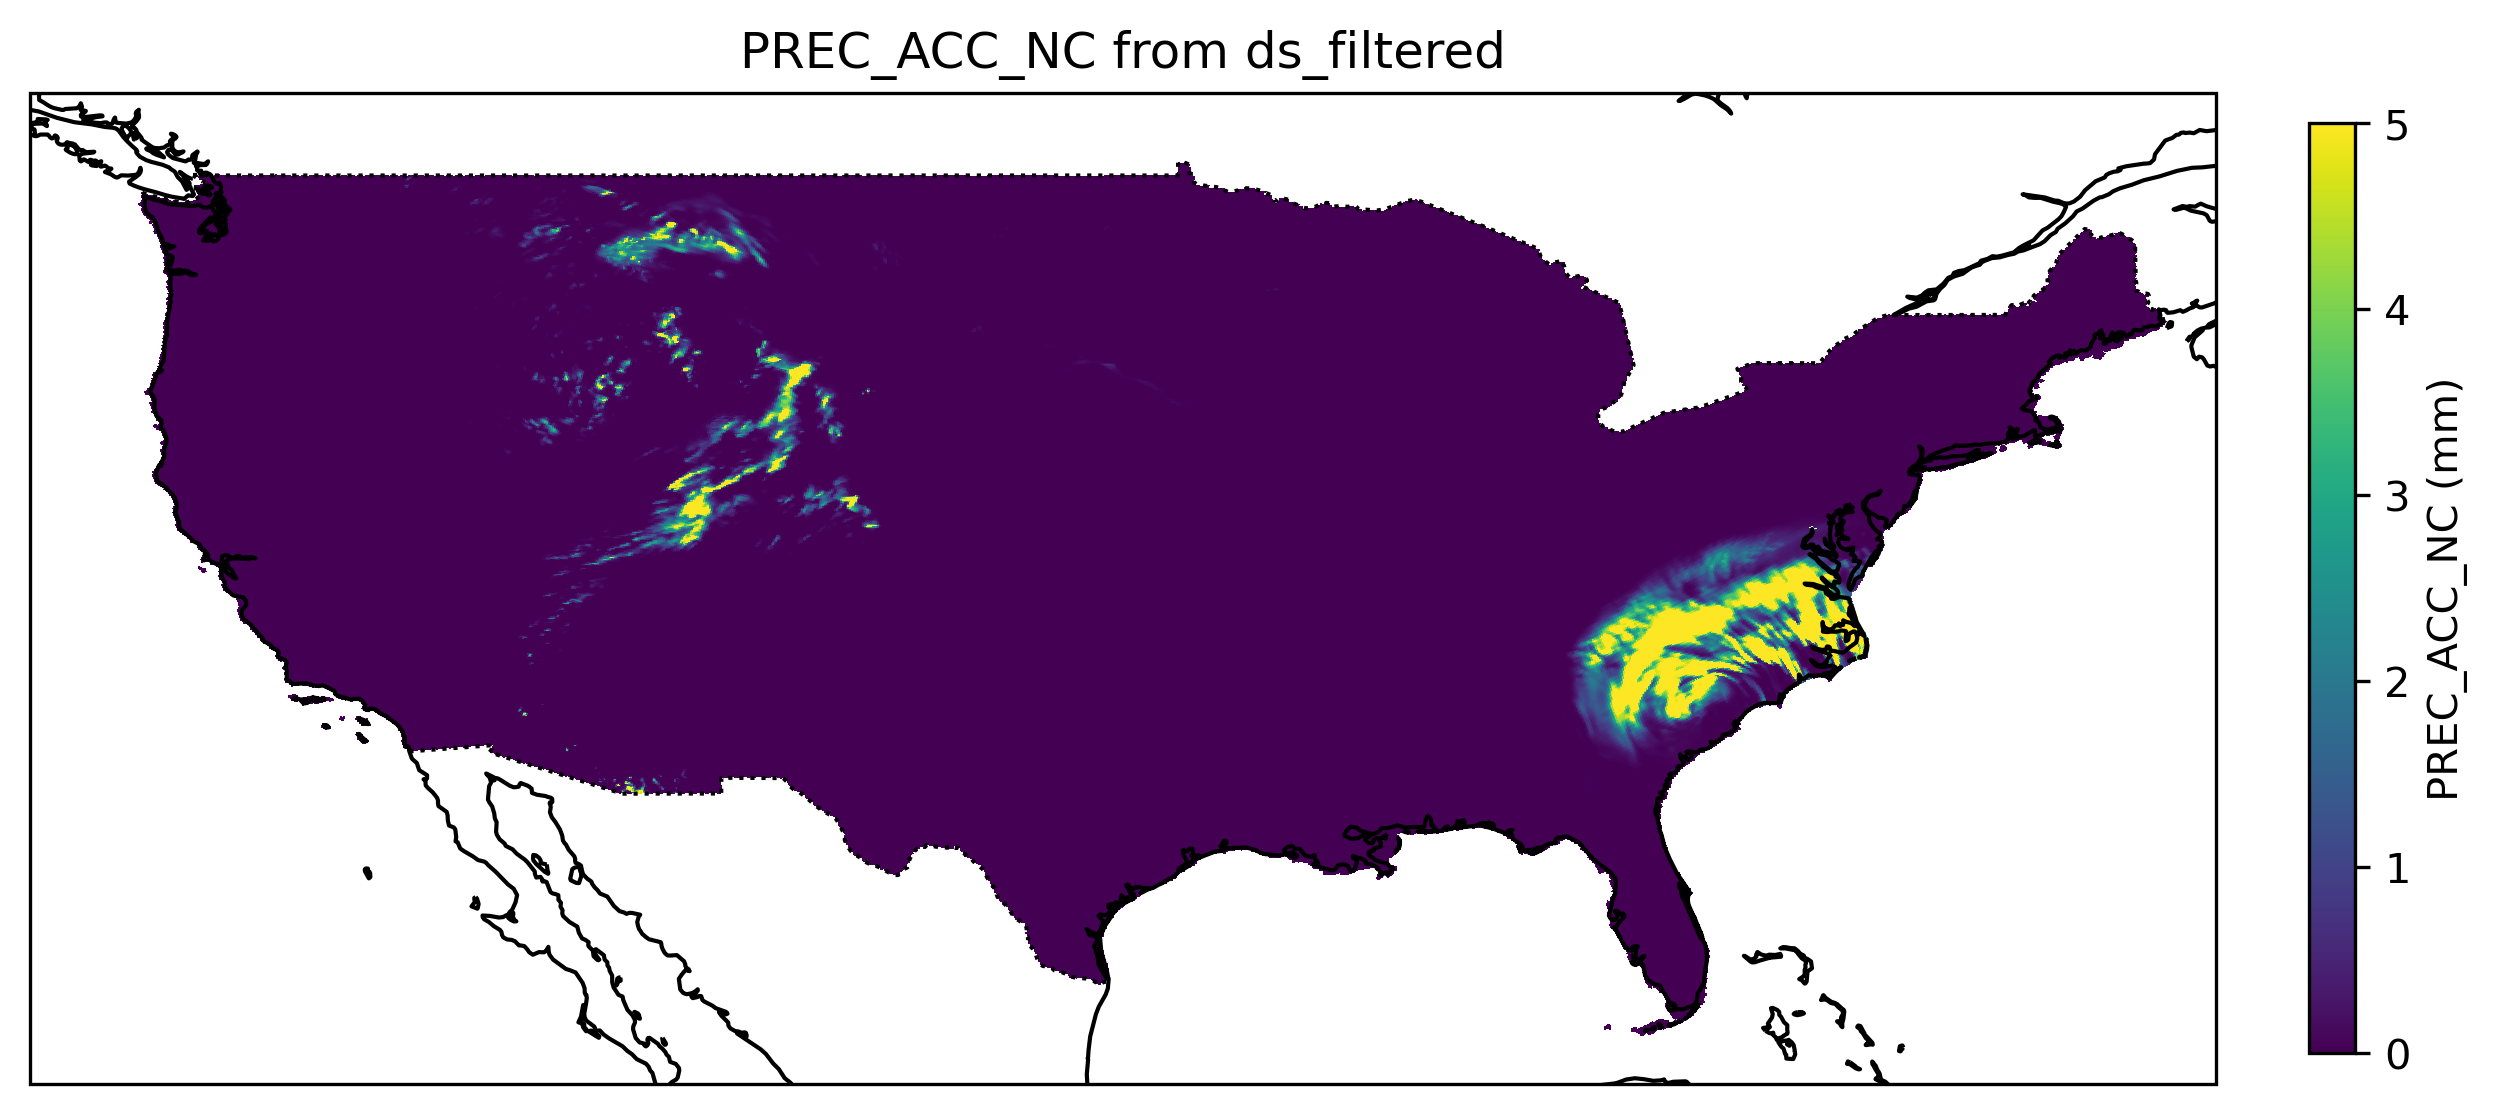

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 提取数据
lon = ds_filtered["XLONG"]
lat = ds_filtered["XLAT"]
precip = ds_filtered["PREC_ACC_NC"].squeeze()  # 去掉时间维度 (Time:1 -> 变成2D)

# 创建地图
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=300)

# 绘制数据
pcm = ax.pcolormesh(lon, lat, precip, transform=ccrs.PlateCarree(), cmap="viridis", vmax = 5)

# 添加地理特征
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# 添加颜色条
cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label("PREC_ACC_NC (mm)")

# 设置标题
ax.set_title("PREC_ACC_NC from ds_filtered")

# 显示图像
plt.show()


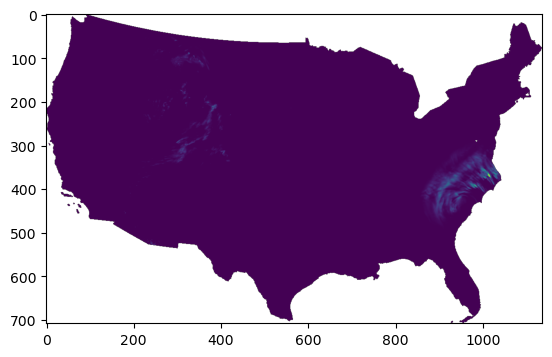

In [21]:
plt.imshow(np.flip(ds_filtered["PREC_ACC_NC"].values[0],axis=0))
plt.show()